In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daphnelee03","key":"4487ad671da4b55e20fe8e45aa639d8e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle

In [5]:
!kaggle datasets download -d jacksoncrow/stock-market-dataset

Dataset URL: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset
License(s): CC0-1.0
100% 521M/522M [00:07<00:00, 79.0MB/s]
100% 522M/522M [00:07<00:00, 71.0MB/s]


In [6]:
import zipfile
import os

# Define the path to the downloaded zip file
zip_file_path = 'stock-market-dataset.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('stock-market-dataset')

# List the files in the directory
os.listdir('stock-market-dataset')

['stocks', 'etfs', 'symbols_valid_meta.csv']

In [7]:
# Define the path to the CSV file
csv_file_path = 'stock-market-dataset/stocks/AMZN.csv'

# Load the CSV file into a DataFrame
data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [8]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by Date
data = data.sort_values('Date')

# Use only the 'Close' price for prediction
close_prices = data['Close'].values

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))


In [10]:
# Create sequences of 60 days for the ANN model
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 67

X, y = create_sequences(close_prices_scaled, sequence_length)

In [11]:
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [12]:
# Flatten the sequences for MLPRegressor
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Define the MLPRegressor model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train_flat, y_train.ravel())


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [13]:
# Predict on the test set
y_pred_scaled = mlp.predict(X_test_flat)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [14]:
# Inverse transform the actual test values
y_test_actual = scaler.inverse_transform(y_test)


# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

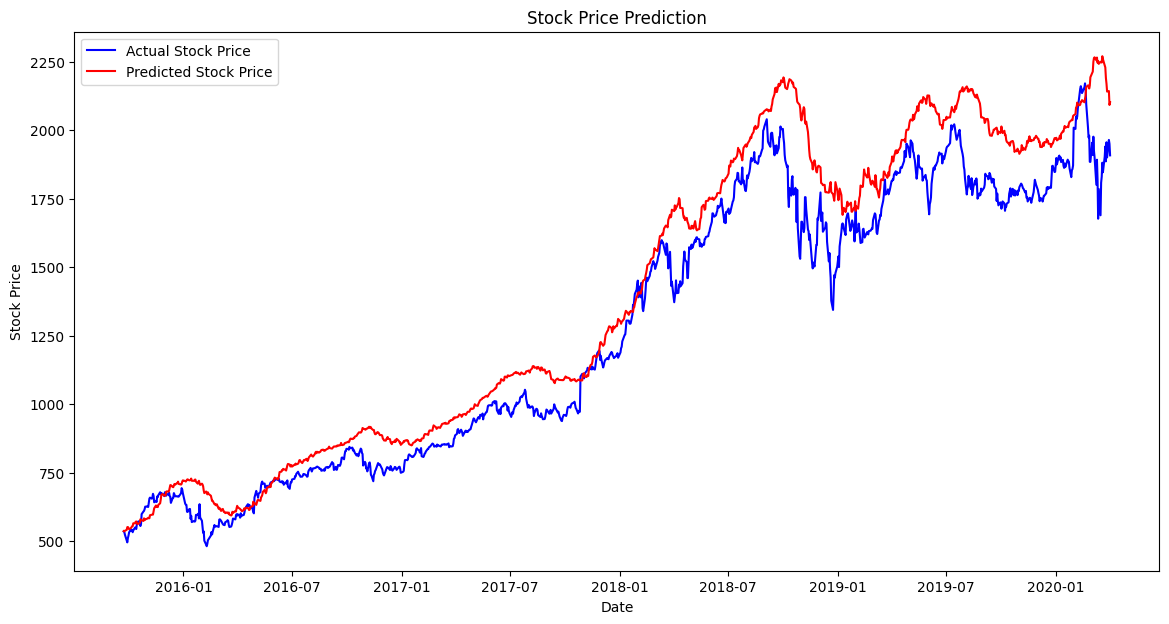

In [15]:
# Plot the predicted vs actual stock prices
plt.figure(figsize=(14, 7))
plt.plot(data['Date'].iloc[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(data['Date'].iloc[-len(y_pred):], y_pred, color='red', label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [16]:
# Display accuracy metrics
print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')

Mean Squared Error: 23683.06145734442
R-Squared: 0.9047476836302597


In [17]:
#Get the quote
#stock_quote = web.DataReader(ticker, data_source='yahoo', start='2012-01-01', end='2020-05-24')
stock_quote=data;
new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-67:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
#Get predicted scaled price
pred_price = mlp.predict(X_test)
#undo the scaling
#pred_price=scaler.inverse_transform(pred_price)
pred_price = scaler.inverse_transform(pred_price.reshape(-1, 1))
print(f'Closing Price of AAPL tomorrow:{pred_price}')

Closing Price of AAPL tomorrow:[[2098.34464288]]


In [18]:
# Number of days to predict into the future
future_days = 30

# Use the last 'sequence_length' days from the training set to make predictions
last_sequence = close_prices_scaled[-sequence_length:].reshape(1, -1)

# List to hold predicted values
future_predictions_scaled = []

In [19]:
# Predict future stock prices
for _ in range(future_days):
    # Predict the next day's price
    next_pred_scaled = mlp.predict(last_sequence)
    future_predictions_scaled.append(next_pred_scaled[0])
    print(f'Predicted Price for Day {len(future_predictions_scaled)}: {next_pred_scaled[0]}')

    # Update the sequence with the predicted value
    last_sequence = np.append(last_sequence[:, 1:], next_pred_scaled.reshape(1, 1), axis=1)


Predicted Price for Day 1: 0.9668597713473612
Predicted Price for Day 2: 0.958126961527624
Predicted Price for Day 3: 0.9646099421053664
Predicted Price for Day 4: 0.9691243081811842
Predicted Price for Day 5: 0.9516458086155404
Predicted Price for Day 6: 0.9497862938211217
Predicted Price for Day 7: 0.9504221425436576
Predicted Price for Day 8: 0.9599343032697889
Predicted Price for Day 9: 0.9621479626076235
Predicted Price for Day 10: 0.9671690122682963
Predicted Price for Day 11: 0.9749350288285707
Predicted Price for Day 12: 0.9986229281196519
Predicted Price for Day 13: 1.0055282361588023
Predicted Price for Day 14: 1.0004618439466668
Predicted Price for Day 15: 1.002411823517878
Predicted Price for Day 16: 1.0084427218369985
Predicted Price for Day 17: 1.0117068196308372
Predicted Price for Day 18: 1.0138905540746377
Predicted Price for Day 19: 1.0134235184227078
Predicted Price for Day 20: 1.0328694640672227
Predicted Price for Day 21: 1.0394334195786876
Predicted Price for Day 

In [20]:
future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)

# Inverse transform the scaled predictions to original scale
future_predictions = scaler.inverse_transform(future_predictions_scaled)

# Generate dates for future predictions
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
print(future_dates)

DatetimeIndex(['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
               '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
               '2020-04-30', '2020-05-01'],
              dtype='datetime64[ns]', freq='D')


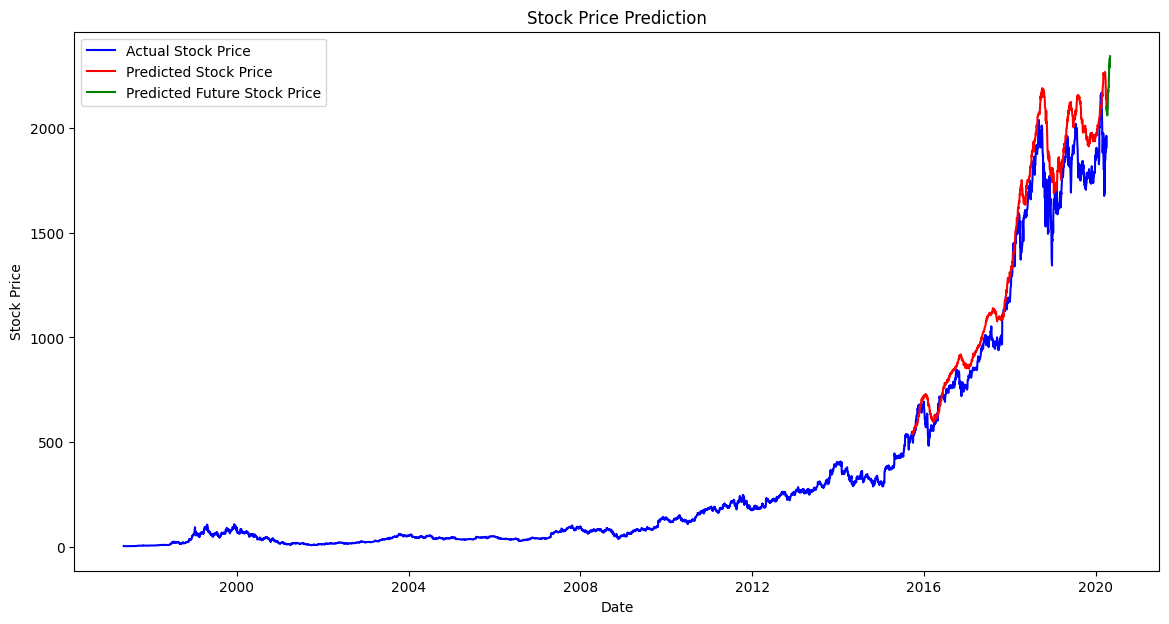

In [21]:
# Plot the actual and predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], close_prices, color='blue', label='Actual Stock Price')
plt.plot(data['Date'].iloc[-len(y_pred):], y_pred, color='red', label='Predicted Stock Price')
plt.plot(future_dates, future_predictions, color='green', label='Predicted Future Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [22]:
# Print future dates and predicted stock prices
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Stock Price': future_predictions.flatten()})
print(future_predictions_df)

         Date  Predicted Stock Price
0  2020-04-02            2098.344643
1  2020-04-03            2079.404714
2  2020-04-04            2093.465159
3  2020-04-05            2103.256025
4  2020-04-06            2065.348233
5  2020-04-07            2061.315273
6  2020-04-08            2062.694317
7  2020-04-09            2083.324521
8  2020-04-10            2088.125558
9  2020-04-11            2099.015332
10 2020-04-12            2115.858456
11 2020-04-13            2167.233344
12 2020-04-14            2182.209743
13 2020-04-15            2171.221629
14 2020-04-16            2175.450792
15 2020-04-17            2188.530750
16 2020-04-18            2195.610004
17 2020-04-19            2200.346140
18 2020-04-20            2199.333221
19 2020-04-21            2241.508058
20 2020-04-22            2255.744123
21 2020-04-23            2307.788861
22 2020-04-24            2301.257309
23 2020-04-25            2307.661647
24 2020-04-26            2289.256551
25 2020-04-27            2293.159000
2